# Reto Intelica

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_diagram
from gtda.mapper import (
    make_mapper_pipeline,
    Projection,
    plot_static_mapper_graph
)
from sklearn.cluster import DBSCAN
from imblearn.over_sampling import SMOTE
import networkx as nx
# np.random.seed(42)
plt.style.use('ggplot')
import kmapper as km

# Clase

### Clase de datos agrícolas

In [69]:
class DatosAgricolas:
    """
    Simulación de datos para productos agrícolas perecederos
    con eventos de mercado, comportamientos de brokers y variables climáticas.
    """
    def __init__(self, params, n_dias=1000, factor=1000):
        self.n_dias = n_dias
        self.fechas = pd.date_range(start="2025-01-01", periods=n_dias, freq='D')
        self.df = None
        self.eventos = None
        # frambuesa data
        self.m_precio_frambuesa = params['precio_frambuesa']/factor
        self.m_precio_frambuesa_var = params['precio_frambuesa_var']/factor
        self.m_volumen_frambuesa = params['volumen_frambuesa']/factor
        self.m_volumen_frambuesa_var = params['volumen_frambuesa_var']/factor
        # aguacate data
        self.m_precio_aguacate = params['precio_aguacate']/factor
        self.m_precio_aguacate_var = params['precio_aguacate_var']/factor
        self.m_volumen_aguacate = params['volumen_aguacate']/factor
        self.m_volumen_aguacate_var = params['volumen_aguacate_var']/factor
        # chile data
        self.m_precio_chile = params['precio_chile']/factor
        self.m_precio_chile_var = params['precio_chile_var']/factor
        self.m_volumen_chile = params['volumen_chile']/factor
        self.m_volumen_chile_var = params['volumen_chile_var']/factor

       
    def generar_base(self):
        """
        Genera datos base para los productos
        """
        # precios base con tendencias estacionales
        tiempo = np.linspace(0, 10, self.n_dias)
        estacionalidad = np.sin(2 * np.pi * tiempo / 365) * 0.2

        # variables climáticas, que cambiarán la calidad de la fruta
        temperatura = 25 + 10 * np.sin(2 * np.pi * tiempo / 365) + np.random.normal(0, 3)
        humedad = 60 + 20 * np.sin(2 * np.pi * tiempo / 365 + np.pi/2) + np.random.normal(0, 5)
        
        # frambuesa - producto altamente perecedero
        # aqui hice el cambio para que no haya ruido y solo un cambio estacional simulado con una funcion sin(x)
        # COMMENT: precio_frambuesa = np.exp(np.random.normal(self.m_precio_frambuesa + estacionalidad, self.m_precio_frambuesa_var, size=self.n_dias))
        precio_frambuesa  = 0.5 * np.sin(tiempo*2*np.pi) # self.m_precio_frambuesa * np.sin(tiempo*2*np.pi) # np.exp(np.random.normal(self.m_precio_frambuesa + estacionalidad, self.m_precio_frambuesa_var, size=self.n_dias))
        volumen_frambuesa = np.random.normal(self.m_volumen_frambuesa, self.m_volumen_frambuesa_var, size=self.n_dias) + np.random.normal(0, 50) * estacionalidad
        calidad_frambuesa = np.clip(0.9 - 0.005*(temperatura-25)**2 - 0.002*(humedad-70)**2 + np.random.normal(0, 0.05), 0.5, 1.0)

        # aguacate - menos perecedero
        precio_aguacate = np.exp(np.random.normal(self.m_precio_aguacate + estacionalidad*0.5, self.m_precio_aguacate_var, size=self.n_dias))
        volumen_aguacate = np.random.normal(self.m_volumen_aguacate, self.m_volumen_aguacate_var, size=self.n_dias) - np.random.normal(0, 70) * estacionalidad
        calidad_aguacate = np.clip(0.95 - 0.003*(temperatura-22)**2 + np.random.normal(0, 0.03), 0.7, 1.0)
        
        # chile seco - producto estable
        precio_chile = np.exp(np.random.normal(self.m_precio_chile + estacionalidad*0.001, self.m_precio_chile_var, size=self.n_dias))
        volumen_chile = np.random.normal(self.m_volumen_chile, self.m_volumen_chile_var, size=self.n_dias)
        calidad_chile = np.clip(0.85 - 0.001*(humedad-50)**2 + np.random.normal(0, 0.04), 0.6, 1.0)
                
        # datos sin modificaciones de brokers
        datos = {
            'fecha': self.fechas,
            'precio_frambuesa': precio_frambuesa,
            'volumen_frambuesa': volumen_frambuesa,
            'calidad_frambuesa': calidad_frambuesa,
            'precio_aguacate': precio_aguacate,
            'volumen_aguacate': volumen_aguacate,
            'calidad_aguacate': calidad_aguacate,
            'precio_chile': precio_chile,
            'volumen_chile': volumen_chile,
            'calidad_chile': calidad_chile,
            'temperatura': temperatura,
            'humedad': humedad,
        }
        
        return pd.DataFrame(datos)
    
    def agregar_eventos_mercado(self, df, interesting):
        """
        Agrega eventos de mercado simulados
        """
        eventos = np.zeros(self.n_dias)

        if not interesting:
            return df, eventos
        
        # frambuesa (perecedero)
        for i in range(130, 170, 5): # for i in range(100, self.n_dias, 180):
            duracion = np.random.randint(5, 15)
            intensidad = np.random.uniform(0.4, 0.7)
            
            # COMMENT:                         variar este |
            df.loc[i:i+duracion, 'precio_frambuesa'] *= -(1 + 0.5*intensidad) if np.random.uniform() < 0.3 else 1
            df.loc[i:i+duracion, 'precio_frambuesa'] -= 3.5*intensidad
            df.loc[i:i+duracion, 'volumen_frambuesa'] *= np.random.uniform(1.2, 1.8)
            eventos[i:i+duracion] = 1  # Evento tipo 1: sobreoferta
            
        # aguacate (especulación)
        for i in range(150, self.n_dias, 220):
            duracion = np.random.randint(10, 20)
            intensidad = np.random.uniform(1.3, 1.8)
            
            df.loc[i:i+duracion, 'precio_aguacate'] *= intensidad
            df.loc[i:i+duracion, 'volumen_aguacate'] *= np.random.uniform(0.6, 0.9)
            eventos[i:i+duracion] = 0  # Evento tipo 2: especulación
            
        # climáticos extremos
        for i in range(200, self.n_dias, 300):
            duracion = np.random.randint(7, 14)
            
            df.loc[i:i+duracion, 'temperatura'] += np.random.uniform(5, 10)
            df.loc[i:i+duracion, 'humedad'] -= np.random.uniform(15, 25)
            eventos[i:i+duracion] = 0  # Evento tipo 3: clima extremo
            
        return df, eventos
    
    def simular_comportamiento_brokers(self, df):
        """
        Simula el comportamiento estratégico de brokers
        """
        # estrategias de brokers basadas en condiciones de mercado
        df['estrategia_broker'] = 'neutral'
        
        # identificar condiciones para diferentes estrategias
        mask_sobreoferta = (df['precio_frambuesa'].pct_change(5) < -0.15)
        mask_especulacion = (df['precio_frambuesa'].pct_change(5) > 0.2)
        mask_clima_extremo = (df['temperatura'] > 32) | (df['humedad'] < 40)
        
        df.loc[mask_sobreoferta, 'estrategia_broker'] = 'liquidacion'
        df.loc[mask_especulacion, 'estrategia_broker'] = 'acaparamiento'
        df.loc[mask_clima_extremo, 'estrategia_broker'] = 'precaucion'
        
        return df
    
    def generar_datos(self, interesting):
        """
        Genera el conjunto completo de datos simulados
        """
        df = self.generar_base()
        df, _ = self.agregar_eventos_mercado(df, interesting)
        df = self.simular_comportamiento_brokers(df)
        
        # agregar elasticidad cruzada simulada
        df['precio_fresa'] = df['precio_frambuesa'] * np.random.uniform(0.8, 1.2)
        df.loc[df['precio_frambuesa'] > df['precio_frambuesa'].quantile(0.8), 'precio_fresa'] *= 1.1
        
        self.df = df

        return df

### Clase Brokers

In [70]:
class SimularBrokers:
    """
    clase para brokers: TODO: documentar
    """
    def __init__(self, df, n_brokers = 2):
        '''
        todo: Documentar
        '''
        self.m_datos = df
        self.m_n_brokers = n_brokers

    def red_brokers(self, df):
        '''
        TODO: documentar
        '''
        # red de brokers
        brokers = [f'broker_{i}' for i in range(1, self.m_n_brokers+1)]
        grafica = nx.Graph()
        grafica.add_nodes_from(brokers)
        
        # conexiones basadas en estrategias
        for _, row in df.iterrows():
            if row['estrategia_broker'] != 'neutral':
                broker1, broker2 = np.random.choice(brokers, 2, replace=False)
                if grafica.has_edge(broker1, broker2):
                    grafica[broker1][broker2]['weight'] += 1
                else:
                    grafica.add_edge(broker1, broker2, weight=1)
            
        return grafica
    
    def plot_brokers(self, grafica):
        '''
        TODO: documentar
        '''
        pos = nx.spring_layout(grafica)
        nx.draw_networkx_nodes(grafica, pos, node_size=200, node_color='lightblue')
        nx.draw_networkx_edges(grafica, pos, width=1.0, alpha=0.5)
        nx.draw_networkx_labels(grafica, pos, font_size=8)
        plt.title("Red de Brokers")
        plt.show()
        # plt.savefig('red_brokers.png')
        plt.close()

### Clase análisis TDA

In [71]:
from gtda.diagrams import PersistenceEntropy, Scaler, Amplitude, PairwiseDistance
from gtda.homology import VietorisRipsPersistence
from gtda.metaestimators import CollectionTransformer
from gtda.pipeline import Pipeline
from gtda.time_series import TakensEmbedding, SingleTakensEmbedding
from gtda.time_series import SlidingWindow
from sklearn.decomposition import PCA
import sys


from gtda.mapper import (
make_mapper_pipeline,
Projection,
plot_static_mapper_graph,
cover, CubicalCover)

class AnalisisTDA:
    """
    Analisis topologico
    """
    def __init__(self, embedding_type = "TK", only_x = True, univariate = False, option_uni = None, persistence_var_type = 'entropy'):
        self.m_embedder   = embedding_type
        self.m_only_x = only_x
        self.m_univariate = univariate
        self.m_option_uni = option_uni
        self.m_persistence_var_type = persistence_var_type

        
    def homologia_persistente(self, x_datos, y_datos=None, embedding_dimension = 2, embedding_time_delay = 1, window_size = 100,  stride = 4):
        """
        homologia persistente usando Vietoris-Rips. TODO: documentar
        """
        if self.m_embedder == "TK" or (self.m_univariate and self.m_option_uni==1):
            embedder = TakensEmbedding(time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride)            
        elif self.m_embedder == "STK" or (self.m_univariate and self.m_option_uni==2):
            embedder = SingleTakensEmbedding(time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride)
        elif self.m_embedder == "SW":
            embedder = SlidingWindow(size = embedding_dimension, stride=stride)
        else:
            sys.exit("Embedder no disponible!")

        persistence = VietorisRipsPersistence(homology_dimensions=[0, 1, 2], n_jobs=-1)
        scaling = Scaler()
        entropy = PersistenceEntropy(normalize=True, nan_fill_value=-10)
        amplitude = Amplitude()

        if self.m_univariate: # one dimensional
            sw = SlidingWindow(size=window_size, stride=stride)
            if self.m_option_uni == 1:   # Option 1: SlidingWindow + TakensEmbedding
                steps_1 = [("sw", sw), ("embedder", embedder), ("persistence", persistence)]
            elif self.m_option_uni == 2: # Option 2: SingleTakensEmbedding + SlidingWindow
                steps_1 = [("embedder", embedder), ("sw", sw), ("persistence", persistence)]
                
        else: # multidimensional or many signals
 
            pca = CollectionTransformer(PCA(n_components=3), n_jobs=-1)
            steps_1 = [("embedder", embedder), ("PCA", pca), ("persistence", persistence)]


        
        if self.m_persistence_var_type == 'entropy':   # Option 1:'entropy'
            steps_2 = [("scaling", scaling), ("entropy", entropy)]
        else:  # Option 2: 'amplitude'
            steps_2 = [("scaling", scaling), ("amplitude", amplitude)]


        topological_transfomer_1 = Pipeline(steps_1)
        topological_transfomer_2 = Pipeline(steps_2)

        if self.m_option_uni==2:
            pca = PCA(n_components=2)
            steps_v = [("embedder", embedder), ("PCA", pca)]
            plot_cloud = Pipeline(steps_v).fit_transform(x_datos)
            

        if self.m_only_x:
                diagramas = topological_transfomer_1.fit_transform(x_datos)
                trans_features = topological_transfomer_2.fit_transform(diagramas)

        if not self.m_univariate:
            return trans_features

        if self.m_option_uni==1:
            return  diagramas[0],trans_features # , labels
        elif self.m_option_uni==2:
            return  diagramas[0],trans_features,plot_cloud
    
    
    def mapper_algorithm(self, datos, n_cubiertas=15, overlap=0.3):
        """
        usar el algoritmo mapper. TODO: documentar 
        """
        # configurar algoritmo mapper
        mapper_algoritmo = make_mapper_pipeline(
            # projection=Projection(columns=list(range(datos.shape[1]))),
            clusterer=DBSCAN(eps=0.3, min_samples=5),
            cover_n_cubes=n_cubiertas,
            cover_perc_overlap=overlap,
            scaler=MinMaxScaler()
        )
        
        # aplicar mapper
        fig = plot_static_mapper_graph(
            mapper_algoritmo,
            datos,
            color_by_columns_dropdown=True,
            node_color_statistic=np.mean
        )
        
        return fig
    
    def diagrama_grafo_broker(self, grafica):
        '''
        documentar y revisar la robustes ante division entre cero
        '''

        adj_matrix = nx.to_numpy_array(grafica, weight='weight')
        distance_matrix = 1 / adj_matrix
        distance_matrix[np.isinf(distance_matrix)] = 0
        vr = VietorisRipsPersistence(metric='precomputed', homology_dimensions=[0, 1, 2])
        return vr.fit_transform(distance_matrix[None, :, :])

    def diagrama_grafo_mapper(self, grafica):
        '''
        documentar y revisar la robustes ante division entre cero
        '''
        adj_matrix = nx.to_numpy_array(grafica)
        distance_matrix = 1 / adj_matrix
        distance_matrix[np.isinf(distance_matrix)] = 0
        vr = VietorisRipsPersistence(metric='precomputed', homology_dimensions=[0, 1, 2])
        return vr.fit_transform(distance_matrix[None, :, :])


    def distancia_dos_diagramas(self, diagrama1, diagrama2, metrica="wasserstein"):
        '''
        documentar
        '''
        distance = PairwiseDistance(metric=metrica)
        return distance.fit_transform([np.array(diagrama1), np.array(diagrama2)])[0, 1]



# Serie de tiempo simulada

In [72]:
params = {
    'precio_frambuesa': 70745,
    'precio_frambuesa_var':2122,
    'volumen_frambuesa':190000,
    'volumen_frambuesa_var':11400,

    'precio_aguacate':20212,
    'precio_aguacate_var':3840,
    'volumen_aguacate':2973000,
    'volumen_aguacate_var':505000,

    'precio_chile':22490,
    'precio_chile_var':787,
    'volumen_chile': 3681000,
    'volumen_chile_var':662580
}

In [73]:
df_not_interesting = DatosAgricolas(params,  n_dias=365).generar_datos(False)
df_interesting = DatosAgricolas(params,  n_dias=365).generar_datos(True)

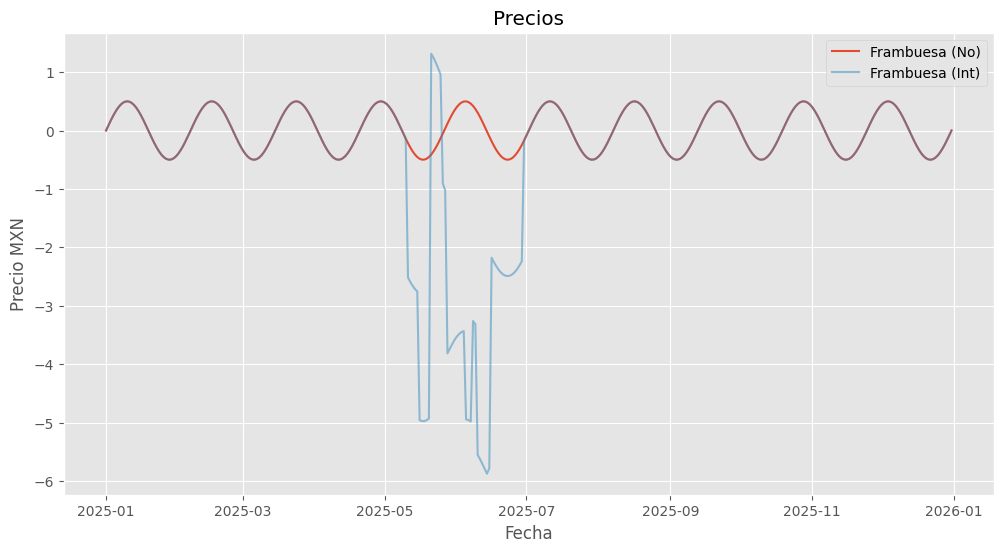

In [74]:
plt.figure(figsize=(12, 6))
plt.plot(df_not_interesting['fecha'], df_not_interesting['precio_frambuesa'], label='Frambuesa (No)')
plt.plot(df_interesting['fecha'], df_interesting['precio_frambuesa'], label='Frambuesa (Int)', alpha = 0.5)
plt.title('Precios')
plt.xlabel('Fecha')
plt.ylabel('Precio MXN')
#plt.yscale("log")
plt.legend()
#plt.grid(True)
plt.show()

### EDA: 

In [75]:
from gtda.plotting import plot_diagram, plot_point_cloud

mi_tda = AnalisisTDA(embedding_type = "STK", univariate = True, option_uni = 2)
X_univariate = np.array(df_interesting["precio_frambuesa"].copy()) # X_train["precio_frambuesa"]

# homologia_persistente(self, datos, embedding_dimension = 2, embedding_time_delay = 1, window_size = 100,  stride = 4)
embedding_dimension = 10
embedding_time_delay = 3
stride = 3
diagrama, features, plot_cloud = mi_tda.homologia_persistente(X_univariate, embedding_dimension = embedding_dimension, embedding_time_delay = embedding_time_delay, window_size = 100,  stride = stride)
# plots
plot_diagram(diagrama)

![alt text](imgs/pers_d_eda.png "Title")

In [76]:
plot_point_cloud(plot_cloud)

![alt text](imgs/point_cloud.png "Title")

In [77]:
mapper = km.KeplerMapper()
lens = PCA(n_components=2).fit_transform(plot_cloud)
graph = mapper.map(lens, plot_cloud, clusterer=DBSCAN(), cover = km.Cover(n_cubes=10, perc_overlap=0.5))
mapper.visualize(graph, path_html="tda_mapper.html");

![alt text](imgs/kmapper.png "Title")

## Series de tiempo simuladas para entrenar clasificador binario

In [78]:
# Generación de N series: interesantes o no interesante

import random

X = []
y = []

N = 100
for i in range(N):
    intr = 1 if random.random() > 0.5 else 0
    df_temp = DatosAgricolas(params, n_dias = 365).generar_datos(intr)
    ts = df_temp['precio_frambuesa'].values
    # print(ts)
    X.append(ts)
    y.append(intr)

X = np.array(X)
y = np.array(y)

X, y


(array([[ 0.00000000e+00,  8.58795265e-02,  1.69206540e-01, ...,
         -1.69206540e-01, -8.58795265e-02, -1.22464680e-15],
        [ 0.00000000e+00,  8.58795265e-02,  1.69206540e-01, ...,
         -1.69206540e-01, -8.58795265e-02, -1.22464680e-15],
        [ 0.00000000e+00,  8.58795265e-02,  1.69206540e-01, ...,
         -1.69206540e-01, -8.58795265e-02, -1.22464680e-15],
        ...,
        [ 0.00000000e+00,  8.58795265e-02,  1.69206540e-01, ...,
         -1.69206540e-01, -8.58795265e-02, -1.22464680e-15],
        [ 0.00000000e+00,  8.58795265e-02,  1.69206540e-01, ...,
         -1.69206540e-01, -8.58795265e-02, -1.22464680e-15],
        [ 0.00000000e+00,  8.58795265e-02,  1.69206540e-01, ...,
         -1.69206540e-01, -8.58795265e-02, -1.22464680e-15]]),
 array([1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
        1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
        0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       

In [79]:
print(f"X shape: {X.shape}")  # debería ser (N, T)
print(f"y shape: {y.shape}")  # debería ser (N,)

X shape: (100, 365)
y shape: (100,)


### Crear features con TDA (Takens Embedding)

In [80]:
tda = AnalisisTDA(only_x=True, univariate=False, embedding_type='TK')

embedding_dimension = 20
embedding_time_delay = 5
stride = 5

features = tda.homologia_persistente(X, embedding_dimension = embedding_dimension, embedding_time_delay = embedding_time_delay, stride = stride)

### Clasificador binario

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score
from sklearn.model_selection import train_test_split

# Split de los datos (asumiendo que X e y ya están definidos)
X_train, X_valid, y_train, y_valid = train_test_split(
    features, y, test_size=0.3, random_state=113
)

# Entrenar modelo de regresión logística
model = LogisticRegression()
model.fit(X_train, y_train)

def print_scores(fitted_model):
    res = {
        "Accuracy on train:": accuracy_score(fitted_model.predict(X_train), y_train),
        "ROC AUC on train:": roc_auc_score(
            y_train, fitted_model.predict_proba(X_train)[:, 1]
        ),
        "Accuracy on valid:": accuracy_score(fitted_model.predict(X_valid), y_valid),
        "ROC AUC on valid:": roc_auc_score(
            y_valid, fitted_model.predict_proba(X_valid)[:, 1]
        ),
        "Precision 1 on train:": precision_score(fitted_model.predict(X_train), y_train, pos_label=1),
        "Precision 0 on train:": precision_score(fitted_model.predict(X_train), y_train, pos_label=0),
        "Precision 1 on valid:": precision_score(fitted_model.predict(X_valid), y_valid, pos_label=1),
        "Precision 0 on valid:": precision_score(fitted_model.predict(X_valid), y_valid, pos_label=0),
    }

    for k, v in res.items():
        print(k, round(v, 3))

print_scores(model)


Accuracy on train: 1.0
ROC AUC on train: 1.0
Accuracy on valid: 1.0
ROC AUC on valid: 1.0
Precision 1 on train: 1.0
Precision 0 on train: 1.0
Precision 1 on valid: 1.0
Precision 0 on valid: 1.0


## Datos Reales

In [82]:
import pandas as pd

# Leer el CSV
df = pd.read_csv("Topo2025_prices_USDA_Clean.csv", parse_dates=["date"])

# Establecer la columna de fechas como índice
df = df.set_index("date")

# Crear un nuevo índice con todas las fechas del rango
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq="D")

# Reindexar para incluir fechas faltantes
df = df.reindex(full_index)

# Rellenar valores faltantes con el valor anterior
df["commodity"] = df["commodity"].ffill()
df["price"] = df["price"].ffill()

# Si quieres volver a tener la columna de fechas como columna normal
df = df.reset_index().rename(columns={"index": "date"})

len(df['price'].values)

365

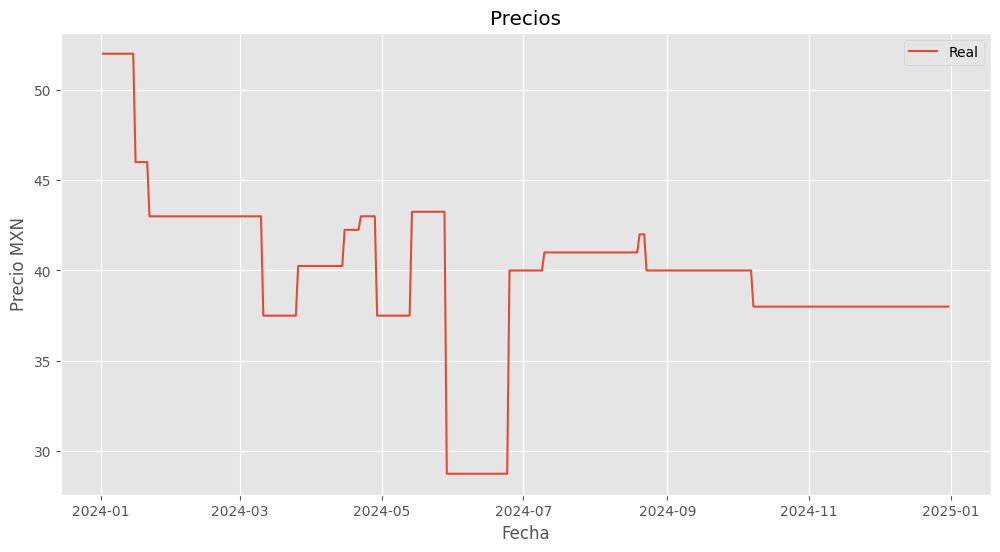

In [83]:
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['price'], label='Real')
# plt.plot(df_for_pers_dgms['fecha'], df_for_pers_dgms['precio_frambuesa'], label='Sintético', alpha = 0.5)
plt.title('Precios')
plt.xlabel('Fecha')
plt.ylabel('Precio MXN')
# plt.yscale("log")
plt.legend()
#plt.grid(True)
plt.show()

### Predicción del modelo Logistic Regression de la serie real

In [84]:
embedding_dimension = 10
embedding_time_delay = 3
stride = 3

_, features_real, _ = mi_tda.homologia_persistente(df['price'].values, embedding_dimension = embedding_dimension, embedding_time_delay = embedding_time_delay,  stride = stride)


model.predict(features_real)[0]

1

Por lo tanto, según el modelo, si hay eventos en la serie

# Descomposición de la serie Real: Raspberries

In [85]:
from statsmodels.tsa.seasonal import STL

decomposition = STL(df["price"], period = 15).fit()

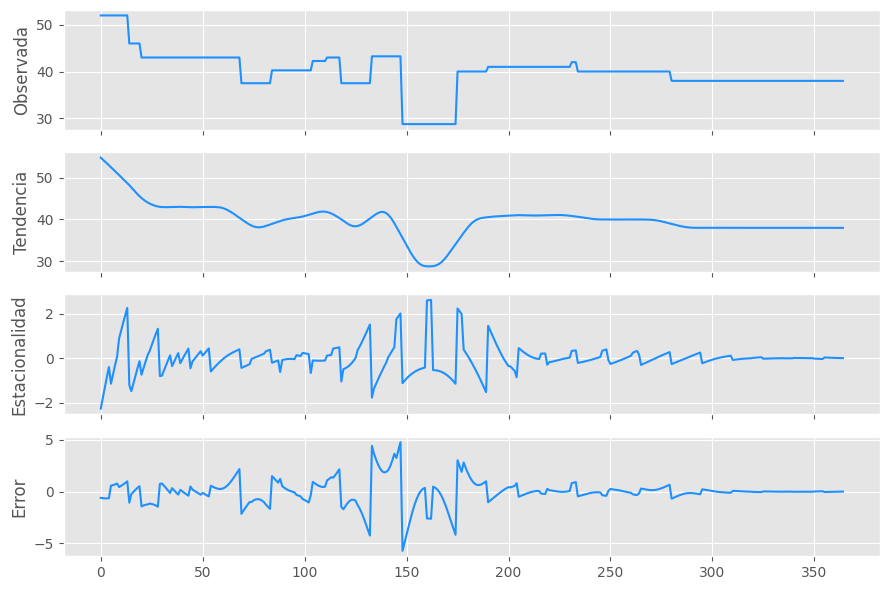

In [86]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 4, ncols = 1, sharex = True)

fig.set_figwidth(9)
fig.set_figheight(6)
ax1.plot(decomposition.observed, color = "dodgerblue")
ax1.set_ylabel("Observada")
ax2.plot(decomposition.trend, color = "dodgerblue")
ax2.set_ylabel("Tendencia")
ax3.plot(decomposition.seasonal, color = "dodgerblue")
ax3.set_ylabel("Estacionalidad")
ax4.plot(decomposition.resid, color = "dodgerblue")
ax4.set_ylabel("Error")
plt.tight_layout()
plt.show();

## Datos sintéticos

In [87]:
n = 365
df_for_pers_dgms = DatosAgricolas(params, n_dias = n).generar_datos(interesting=True)

# PARA LOS DATOS SINTÉTICOS

In [88]:
# ------------------------------------------------

mi_tda = AnalisisTDA(embedding_type = "STK", univariate = True, option_uni = 2)
X_univariate = df_for_pers_dgms["precio_frambuesa"].values

# homologia_persistente(self, datos, embedding_dimension = 2, embedding_time_delay = 1, window_size = 100,  stride = 4)
embedding_dimension = 10
embedding_time_delay = 3
stride = 3
diagrama_sint, features, plot_cloud = mi_tda.homologia_persistente(X_univariate, embedding_dimension = embedding_dimension, embedding_time_delay = embedding_time_delay, window_size = 100,  stride = stride)

# plots
plot_diagram(diagrama_sint)

![alt text](imgs/pers_d_sint.png "Title")

# PARA LOS DATOS REALES

In [89]:
mi_tda = AnalisisTDA(embedding_type = "STK", univariate = True, option_uni = 2)
# X_univariate = df["price"].values

X_univariate = decomposition.seasonal.values

# homologia_persistente(self, datos, embedding_dimension = 2, embedding_time_delay = 1, window_size = 100,  stride = 4)
embedding_dimension = 5
embedding_time_delay = 1
stride = 1
diagrama_real, features, plot_cloud = mi_tda.homologia_persistente(X_univariate, embedding_dimension = embedding_dimension, embedding_time_delay = embedding_time_delay, window_size = 100,  stride = stride)

# plots
plot_diagram(diagrama_real)

![alt text](imgs/pers_d_real.png "Title")

In [90]:
diagrama_sint.shape, diagrama_real[:119].shape

((123, 3), (119, 3))

### ESTACIONALIDAD: Serie Real vs Simulada

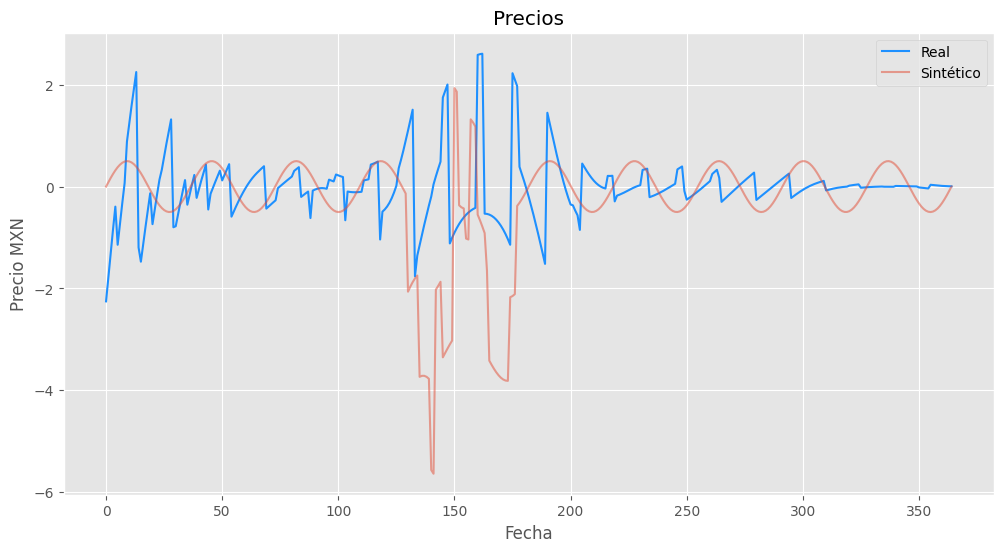

In [91]:
plt.figure(figsize=(12, 6))
plt.plot(decomposition.seasonal, color = "dodgerblue", label='Real')
plt.plot(df_for_pers_dgms['precio_frambuesa'], label='Sintético', alpha = 0.5)
plt.title('Precios')
plt.xlabel('Fecha')
plt.ylabel('Precio MXN')
# plt.yscale("log")
plt.legend()
#plt.grid(True)
plt.show()

# Distancia entre diagrama de persistencia de datos reales vs sintética

In [92]:
import numpy as np

def pad_diagrams(diag1, diag2, dim):
    d1 = diag1[diag1[:, 2] == dim]
    d2 = diag2[diag2[:, 2] == dim]
    
    len1, len2 = len(d1), len(d2)

    if len1 < len2:
        padding = np.array([[0.0, 0.0, dim]] * (len2 - len1))
        d1 = np.vstack([d1, padding])
    elif len2 < len1:
        padding = np.array([[0.0, 0.0, dim]] * (len1 - len2))
        d2 = np.vstack([d2, padding])
        
    # También devolvemos las otras dimensiones sin cambios
    rest1 = diag1[diag1[:, 2] != dim]
    rest2 = diag2[diag2[:, 2] != dim]

    diag1_padded = np.vstack([d1, rest1])
    diag2_padded = np.vstack([d2, rest2])

    return diag1_padded, diag2_padded


In [93]:
def pad_all_dimensions(d1, d2):
    dims = set(np.unique(d1[:, 2])).union(set(np.unique(d2[:, 2])))
    for dim in dims:
        d1, d2 = pad_diagrams(d1, d2, dim)
    return d1, d2


In [94]:
# Padding en todas las dimensiones
d1_padded, d2_padded = pad_all_dimensions(diagrama_sint, diagrama_real[:119])

# Asegúrate que ambos tengan misma forma
assert d1_padded.shape == d2_padded.shape, "Los diagramas no tienen la misma forma tras el padding"

# Forma final requerida por PairwiseDistance
diagrams_array = np.array([d1_padded, d2_padded])  # shape (2, n_points, 3)

from gtda.diagrams import PairwiseDistance
dist = PairwiseDistance(metric="wasserstein")
result = dist.fit_transform(diagrams_array)[0, 1]

print("Distancia Wasserstein:", result)


Distancia Wasserstein: 6.273994523594555


# Comparación vs línea recta (relevancia de la distancia)

### Línea Recta

In [95]:
X_univariate = np.arange(1, 366, 1)

# homologia_persistente(self, datos, embedding_dimension = 2, embedding_time_delay = 1, window_size = 100,  stride = 4)
embedding_dimension = 10
embedding_time_delay = 3
stride = 3
diagrama_linea_recta, _, _ = mi_tda.homologia_persistente(X_univariate, embedding_dimension = embedding_dimension, embedding_time_delay = embedding_time_delay, window_size = 100,  stride = stride)

# plots
plot_diagram(diagrama_linea_recta)

![alt text](imgs/pers_d_lr.png "Title")

### Distancia: Datos Reales vs Línea Recta

In [96]:
# Padding en todas las dimensiones
d1_padded, d2_padded = pad_all_dimensions(diagrama_real, diagrama_linea_recta)

# Asegúrate que ambos tengan misma forma
assert d1_padded.shape == d2_padded.shape, "Los diagramas no tienen la misma forma tras el padding"

# Forma final requerida por PairwiseDistance
diagrams_array = np.array([d1_padded, d2_padded])  # shape (2, n_points, 3)

from gtda.diagrams import PairwiseDistance
dist = PairwiseDistance(metric="wasserstein")
result = dist.fit_transform(diagrams_array)[0, 1]

print("Distancia Wasserstein:", result)

Distancia Wasserstein: 21.300409750540545


### Distancia: Datos Sintéticos vs Línea Recta

In [97]:
# Padding en todas las dimensiones
d1_padded, d2_padded = pad_all_dimensions(diagrama_sint, diagrama_linea_recta)

# Asegúrate que ambos tengan misma forma
assert d1_padded.shape == d2_padded.shape, "Los diagramas no tienen la misma forma tras el padding"

# Forma final requerida por PairwiseDistance
diagrams_array = np.array([d1_padded, d2_padded])  # shape (2, n_points, 3)

from gtda.diagrams import PairwiseDistance
dist = PairwiseDistance(metric="wasserstein")
result = dist.fit_transform(diagrams_array)[0, 1]

print("Distancia Wasserstein:", result)

Distancia Wasserstein: 20.21198691053966


Para comparar la estructura topológica de los datos simulados y reales, calculamos la distancia Wasserstein entre sus diagramas de persistencia, que representan la aparición y desaparición de características topológicas como componentes y ciclos. Esta distancia mide qué tan diferentes son estas estructuras entre ambos conjuntos. Un valor de 6.582 indica una diferencia moderada; mientras 0 significaría diagramas idénticos, valores más altos reflejan mayor discrepancia. Para calcular esta distancia, se ajustaron los diagramas agregando puntos triviales para que tuvieran igual cantidad de elementos en cada dimensión, requisito para la comparación.

[ ] kmapper para eda explicarlo, motivación, que se interpreta del grafo

[ ] Sliding windows - PCA (persistence dgms)

[ ] Métricas de clasificadores

[ ] Embeddings: X -> pipeline (takens) -> features 

[ ] Estadística: distribuciones de métricas y prueba de medias

[ ] Hacer un análisis sobre la componente estacional de la serie de tiempo, asimilamos serie sintética a la real